## Gap case 2

This notebook describes a test case with one ``Ingestion-Walltime-Us`` values gap of ~20 s.

The case is characterized by a small ``Ingestion-Walltime-Us`` difference value of ~1.4 s just after the gap. There is a video jump caused by missing frames in the segment following the gap.

The video segments are from *Webcam Zürich HB* live stream: https://www.youtube.com/watch?v=kHwmzef842g.

In [1]:
from datetime import datetime, timedelta, timezone
from itertools import groupby
from pathlib import Path
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import seaborn as sns
from brokenaxes import brokenaxes, BrokenAxes

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.collections import LineCollection
from matplotlib.markers import MarkerStyle, CapStyle
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, MultipleLocator

from src.common import discrete_diff, interpolate_point
from src.display import display_first_video_frame, display_last_video_frame
from src.plotting import PlainOffsetScalarFormatter, plot_hat_graph, plot_ingestion_line

%load_ext autoreload
%autoreload 1

%aimport src.common
%aimport src.display
%aimport src.plotting

In [2]:
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=mpl.cm.Set2.colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [3]:
pd.set_option("display.float_format", "{:f}".format)

In [4]:
figure_dpi = 100
figure_size = (w := 640 / figure_dpi, w / 1.5)

In [5]:
SHARED_PATH = Path("./shared/")

In [6]:
SEGMENT_DURATION = 2.0
STREAM_TIMEZONE = ZoneInfo("Europe/Zurich")

## Loading data

In [7]:
data = pd.read_csv(
    SHARED_PATH / "gap-cases/2/gaps-case-2-i244-metadata.csv",
    usecols=["sequence","Ingestion-Walltime-Us","Stream-Duration-Us"]
)
data = data.set_index("sequence")
data /= 1e6

In [8]:
durations = pd.read_csv(
    SHARED_PATH / "gap-cases/2/gaps-case-2-i244-duration.csv",
     index_col="sequence"
)
data = pd.concat([data, durations], axis=1)
data = data.loc[:,~data.columns.duplicated()]

with pd.option_context("display.max_rows", 12):
    display(data)

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7947314,1679763560.320209,15894218.405000,2.000000
7947315,1679763562.309520,15894220.405000,1.934000
7947316,1679763564.220385,15894222.405000,2.066000
7947317,1679763566.309040,15894224.405000,1.934000
7947318,1679763568.217062,15894226.405000,2.066000
...,...,...,...
7947350,1679763652.004910,15894289.805000,2.000000
7947351,1679763654.004885,15894291.805000,2.000000
7947352,1679763656.008294,15894293.805000,2.000000


## Plotting data

### Ingestion-Walltime-Us values

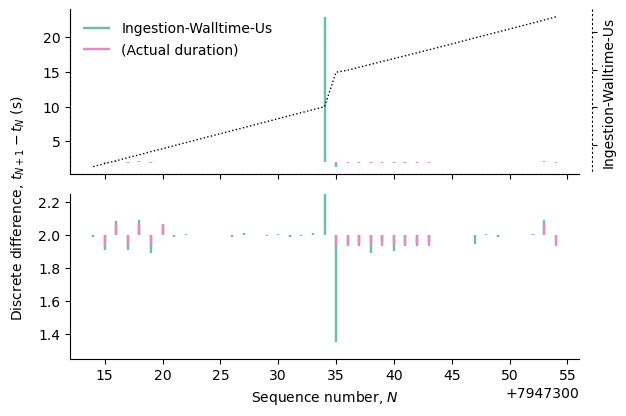

In [9]:
fig, axs = plt.subplots(2, 1, figsize=figure_size, dpi=figure_dpi, sharex=True, height_ratios=(1, 1)) 

ax, axb = axs


# Main axis
ax.vlines(
    x=data.index,
    ymin=2,
    ymax=discrete_diff(data["Ingestion-Walltime-Us"]),
    colors="C0",
    lw=1.75,
    label="Ingestion-Walltime-Us"
)
ax.vlines(
    x=data.index,
    ymin=2,
    ymax=data["duration"],
    colors="C3",
    lw=1.75,
    label="(Actual duration)"
)

sns.despine(ax=ax)

# Secondary axis
ax2 = ax.twinx()

ax2.plot(data.index, data["Ingestion-Walltime-Us"], ls=":", c="k", lw=1)

ax2.tick_params(axis="y", which="both", right=True, labelright=False)
ax2.set_ylabel("Ingestion-Walltime-Us")

ax2.spines.right.set_position(("axes", 1.025))
sns.despine(ax=ax2, right=False)
for spine in ax2.spines.values():
    spine.set_linestyle((1, (1, 3)))

    
# Bottom axis
axb.vlines(
    x=data.index,
    ymin=2,
    ymax=discrete_diff(data["Ingestion-Walltime-Us"]),
    colors="C0",
    lw=1.75,
    label="Ingestion-Walltime-Us"
)

axb.vlines(
    x=data.index,
    ymin=2,
    ymax=data["duration"],
    colors="C3",
    lw=1.75,
    label="(Actual duration)"
)

axb.xaxis.set_major_formatter(PlainOffsetScalarFormatter())
axb.set_ylim(1.25, 2.25)

sns.despine(ax=axb)


ax.legend(frameon=False, loc=2)

axb.set_xlabel("Sequence number, $N$")
fig.supylabel("Discrete difference, $t_{N + 1} - t_N$ (s)", fontsize=10, x=0.03)

plt.tight_layout()
plt.show()

## Narrow to the gap

In [10]:
gap_start_idx = discrete_diff(data["Ingestion-Walltime-Us"]).idxmax()
ingestion_diff_value = data.loc[gap_start_idx+1, "Ingestion-Walltime-Us"] - data.loc[gap_start_idx, "Ingestion-Walltime-Us"]
gap_length = ingestion_diff_value - data.loc[gap_start_idx, "duration"]
print(f"Gap length ({gap_start_idx}-{gap_start_idx + 1}): {gap_length:f} s")

Gap length (7947334-7947335): 20.946994 s


In [11]:
gap_data = data.loc[7947334-20:7947334+20]
with pd.option_context("display.max_rows", 8):
    display(gap_data)

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7947314,1679763560.320209,15894218.405000,2.000000
7947315,1679763562.309520,15894220.405000,1.934000
7947316,1679763564.220385,15894222.405000,2.066000
7947317,1679763566.309040,15894224.405000,1.934000
...,...,...,...
7947351,1679763654.004885,15894291.805000,2.000000
7947352,1679763656.008294,15894293.805000,2.000000
7947353,1679763658.016958,15894295.805000,2.067000
7947354,1679763660.111397,15894297.805000,1.933000


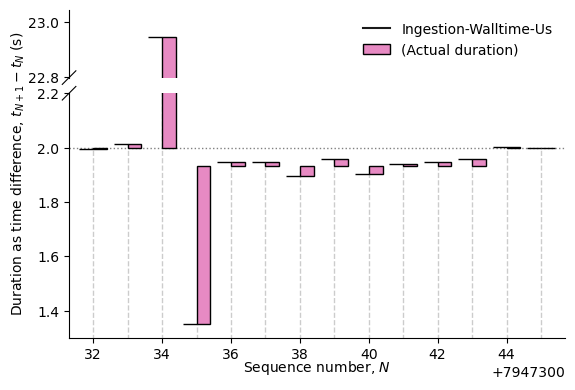

In [12]:
w, h = figure_size
fig = plt.figure(figsize=(w, h * 1), dpi=figure_dpi)

plot_data = gap_data.loc[7947332:7947346]

max_ingestion_diff_value = discrete_diff(plot_data["Ingestion-Walltime-Us"]).max()
ylims = [
    (1.3, 2.2),
    (max_ingestion_diff_value - 0.15, max_ingestion_diff_value + 0.1)
]

bax = brokenaxes(ylims=ylims, hspace=0.1, tilt=45)
bax.axs[0].set_yticks([])

y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
plot_hat_graph(bax, sequences=plot_data.index, y1=y1, y2=y2, width=0.2, baseline=SEGMENT_DURATION)

bax.axs[1].vlines(plot_data.index, ymin=0, ymax=y1.fillna(0), lw=1, ls="--", colors="0.8", zorder=0)

plt.show()

### Test points

In [13]:
gap_data.loc[7947335, "Ingestion-Walltime-Us"] + gap_data.loc[7947335, "duration"]

1679763625.149888

In [14]:
gap_data.loc[7947336, "Ingestion-Walltime-Us"]

1679763624.566461

In [15]:
y_S2 = gap_data.loc[7947334, "Ingestion-Walltime-Us"] + gap_data.loc[7947335, "duration"] / 2

ingestion_diff = gap_data.loc[7947336, "Ingestion-Walltime-Us"] - gap_data.loc[7947335, "Ingestion-Walltime-Us"]
ingestion_duration_diff = ingestion_diff - gap_data.loc[7947335, "duration"]
y_S4 = gap_data.loc[7947336, "Ingestion-Walltime-Us"] - ingestion_duration_diff / 2
assert y_S4 < gap_data.loc[7947335, "Ingestion-Walltime-Us"] + gap_data.loc[7947335, "duration"]
assert y_S4 > gap_data.loc[7947336, "Ingestion-Walltime-Us"]

points_list = [
    ("S_1", interpolate_point(7947333.5, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_2", interpolate_point(y_S2, gap_data["Ingestion-Walltime-Us"], gap_data.index)[::-1]),
    ("S_3/E_3", interpolate_point(7947334.5, gap_data.index, gap_data["Ingestion-Walltime-Us"])),
    ("S_4", (7947335.999, y_S4)),
]

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

    Point S_1: segment 7947333, 1679763599.262686
    Point S_2: segment 7947334, 1679763601.235894
Point S_3/E_3: segment 7947334, 1679763611.742391
    Point S_4: segment 7947335, 1679763624.858175


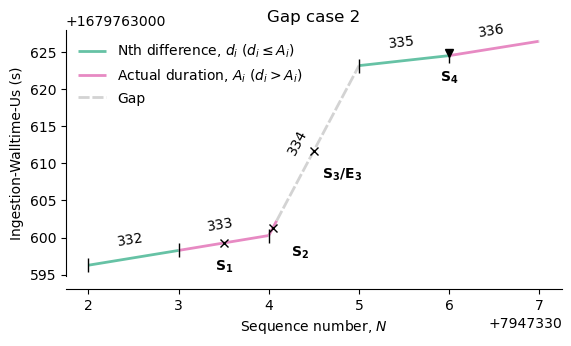

    Point S_1: segment 7947333, 1679763599.262686
    Point S_2: segment 7947334, 1679763601.235894
Point S_3/E_3: segment 7947334, 1679763611.742391
    Point S_4: segment 7947335, 1679763624.858175


In [16]:
w, h = figure_size

fig, ax = plt.subplots(1, 1, figsize=(w, h * 0.75), dpi=figure_dpi) 

plot_data = gap_data.loc[7947334-2:7947337]

plot_ingestion_line(ax, plot_data, color="lightcoral")

for label, point in points_list:
    match label:
        case "S_2":
            xytext = (20, -20)
        case "S_3/E_3":
            xytext = (20, -20)
        case _:
            xytext = (0, -20)
            
    match label:
        case "S_4":
            marker = "v"
        case _:
            marker = "x"
            
    ax.plot(*point, marker=marker, color="k", mec="k", ms=6, mew=1)
    ax.annotate(f"$\mathbf{{{label}}}$", point, xytext=xytext, textcoords="offset points", ha="center")
    
plt.legend(frameon=False, loc=2)
    
#plt.xlabel("Sequence number, $N$")
#plt.ylabel("Ingestion-Walltime-Us (s)")

plt.title("Gap case 2")

plt.show()

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

In [17]:
gap_data.loc[7947335, "Ingestion-Walltime-Us"] + 1

1679763624.215888

In [18]:
gap_data.loc[7947336, "Ingestion-Walltime-Us"]

1679763624.566461

In [19]:
y_S4 - plot_data.loc[7947336, "Ingestion-Walltime-Us"]

0.2917134761810303

In [20]:
plot_data.loc[7947335, "Ingestion-Walltime-Us"]

1679763623.215888

In [21]:
print(datetime.fromtimestamp(1679763623.215888))

2023-03-25 20:00:23.215888


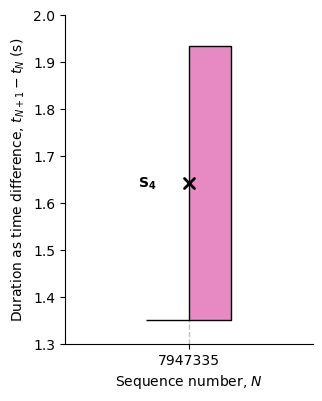

In [22]:
w, h = figure_size
fig, ax = plt.subplots(1, 1, figsize=(w * 0.5, h), dpi=figure_dpi)

plot_data = gap_data.loc[7947335:7947336]
y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
plot_hat_graph(ax, sequences=plot_data.index, y1=y1, y2=y2, width=0.12)

ymin = 1.3
ax.vlines(plot_data.index, ymin=ymin, ymax=y1.fillna(0), lw=1, ls="--", colors="silver", zorder=0)

point = (7947335, y_S4 - plot_data.loc[7947335, "Ingestion-Walltime-Us"])
ax.plot(*point, marker=MarkerStyle('x', capstyle=CapStyle.round), mec="k", mew=2, ms=7)
plt.annotate("$\mathbf{S_4}$", point, xytext=(-30, 0), textcoords="offset points", ha="center", va="center")

ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.xticks([7947335])
plt.ylim(ymin, 2)

ax.get_legend().remove()

plt.show()

In [23]:
# w, h = figure_size
# fig, ax = plt.subplots(1, 1, figsize=(w * 0.5, h), dpi=figure_dpi)

# plot_data = gap_data.loc[7947336:7947337]
# y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
# plot_hat_graph(ax, sequences=plot_data.index, y1=y1, y2=y2, width=0.12)

# ymin = 1.88
# ax.vlines(plot_data.index, ymin=ymin, ymax=y1.fillna(0), lw=1, ls="--", colors="silver", zorder=0)

# point = (7947336, y_S5 - plot_data.loc[7947336, "Ingestion-Walltime-Us"])
# ax.plot(*point, marker=MarkerStyle('x', capstyle=CapStyle.round), mec="k", mew=2, ms=7)
# plt.annotate("$\mathbf{S_5}$", point, xytext=(0, 30), textcoords="offset points", ha="center", va="center")

# ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))

# plt.xticks([7947336])
# plt.ylim(ymin, 2)

# ax.get_legend().remove()

# plt.show()

### Selected video frames

In [24]:
SEGMENTS_DIR = SHARED_PATH / "gap-cases" / "2"

Segment 7947334


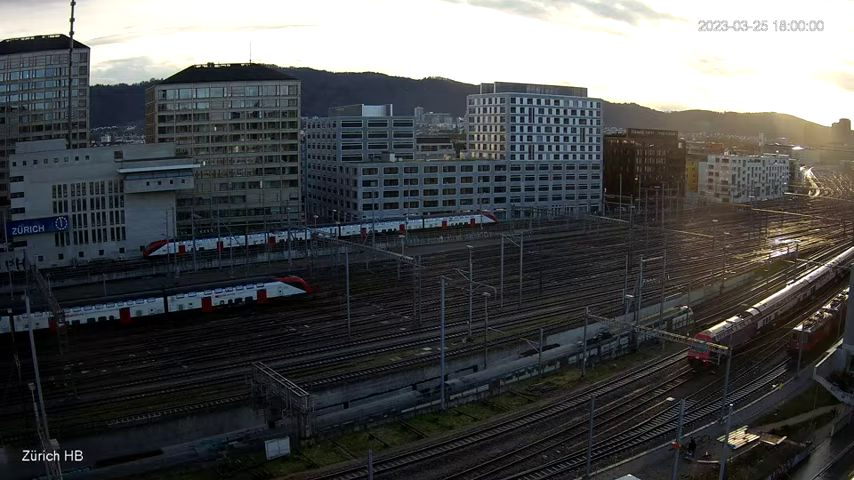

Ingestion-Walltime-Us: 2023-03-25 18:00:00.268894+01:00


In [25]:
sequence = 7947334
print(f"Segment {sequence}")
display_first_video_frame(SEGMENTS_DIR / f"zur-{sequence}-i244.webm")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

Segment 7947335
First frame:


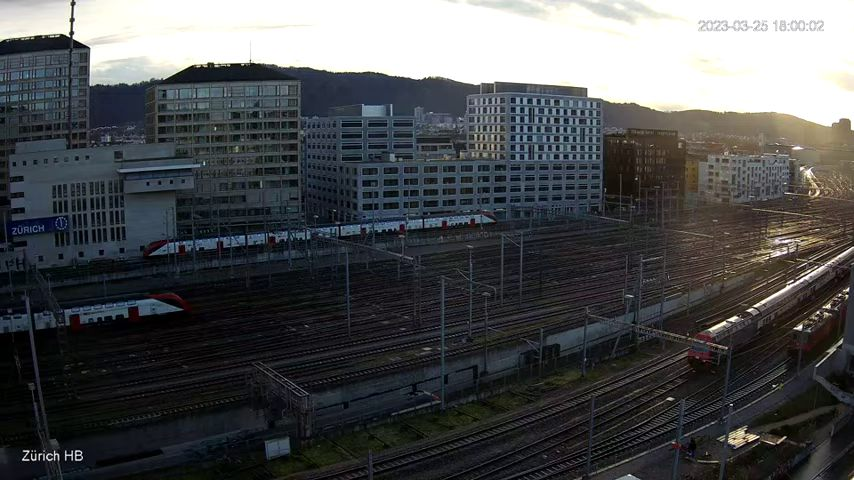

Ingestion-Walltime-Us: 2023-03-25 18:00:23.215888+01:00

Last frame:


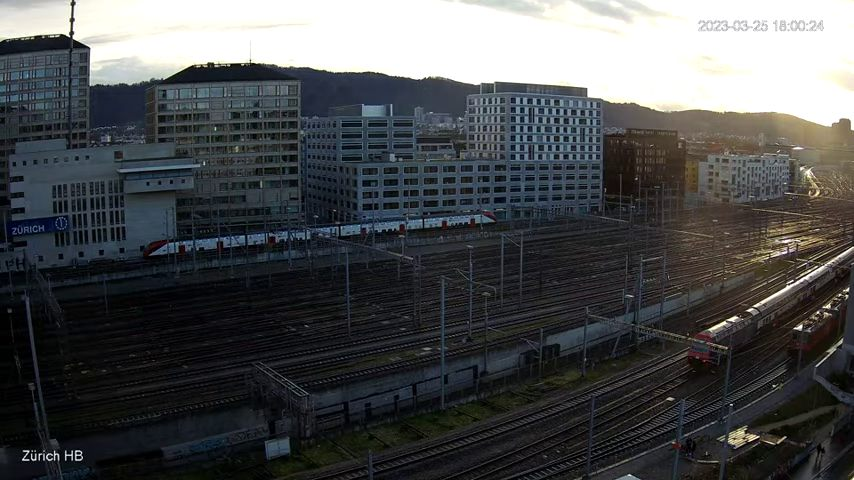

In [26]:
sequence = 7947335
print(f"Segment {sequence}")

print("First frame:")
display_first_video_frame(SEGMENTS_DIR / f"zur-{sequence}-i244.webm")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence, "Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

print()
print("Last frame:")
display_last_video_frame(SEGMENTS_DIR / f"zur-{sequence}-i244.webm")

Segment 7947336


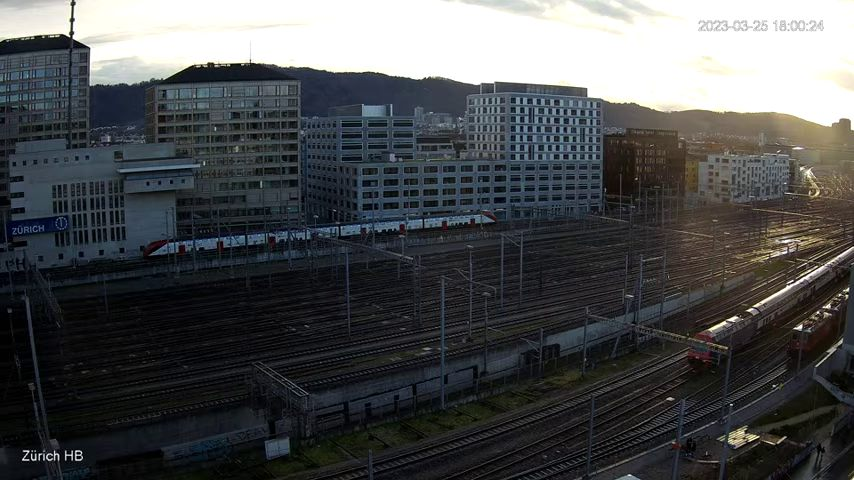

Ingestion-Walltime-Us: 2023-03-25 18:00:24.566461+01:00


In [27]:
sequence = 7947336
print(f"Segment {sequence}")
display_first_video_frame(SEGMENTS_DIR / f"zur-{sequence}-i244.webm")
print(
    "Ingestion-Walltime-Us:",
    datetime.fromtimestamp(gap_data.loc[sequence]["Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

### Exporting fixture data

In [28]:
to_export = gap_data[["Ingestion-Walltime-Us", "duration"]].copy()
to_export["Ingestion-Walltime-Us"] = to_export["Ingestion-Walltime-Us"].apply(lambda x: int(x * 1e6)) 

output_path = Path("./out/gap-cases/gap-case-2-fixture.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)

to_export.to_csv(output_path)
with pd.option_context("display.max_rows", 8):
    display(to_export)

,Ingestion-Walltime-Us,duration
sequence,,
7947314,1679763560320209,2.000000
7947315,1679763562309520,1.934000
7947316,1679763564220385,2.066000
7947317,1679763566309040,1.934000
...,...,...
7947351,1679763654004885,2.000000
7947352,1679763656008294,2.000000
7947353,1679763658016958,2.067000
7947354,1679763660111397,1.933000
